**<h1>THE MATHEMATICAL BUILDING BLOCKS OF NEURAL NETWORKS**

# *A FIRST LOOK AT A NEURAL NETWORK*

In [5]:
# Creating the model
import torch
from torch import nn
# selecting device
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Device:", device)

Device: mps


In [6]:
# Reproduction
torch.manual_seed(42)

In [7]:
# loading data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081)) # MNIST stats
])

# Location of data
DATA_DIR = 'data'
train_ds = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transforms)
test_ds = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transforms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=2, pin_memory=(device.type=='cuda'))
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False,
                         num_workers=2, pin_memory=(device.type=='cuda'))


In [8]:
# Model
from torch import nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x
    
model = MNIST_CNN().to(device)


In [9]:
# Optimezer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [10]:
# Train
def train_epoch():
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_train.size(0)
        pred = preds.argmax(1)
        correct += (pred == y_train).sum().item()
        total += X_train.size(0)
    return total_loss/total, correct/total



In [11]:
# evaluate
@ torch.no_grad()
def evaluate():
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss / total, correct / total

In [12]:
# loop
EPOCHS = 5
for epoch in range(EPOCHS+1):
    tr_loss, tr_acc = train_epoch()
    te_loss, te_acc = evaluate()
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} "
          f"| test loss {te_loss} acc {te_acc:.4f}")

Epoch 00 | train loss 0.1698 acc 0.9464 | test loss 0.0473340841203928 acc 0.9838
Epoch 01 | train loss 0.0576 acc 0.9826 | test loss 0.03359404293298721 acc 0.9884
Epoch 02 | train loss 0.0426 acc 0.9868 | test loss 0.029615993732213974 acc 0.9896
Epoch 03 | train loss 0.0334 acc 0.9894 | test loss 0.033102848029136656 acc 0.9904
Epoch 04 | train loss 0.0277 acc 0.9908 | test loss 0.028795895338058472 acc 0.9914
Epoch 05 | train loss 0.0227 acc 0.9926 | test loss 0.02116601152420044 acc 0.9937


In [13]:
# save the model
torch.save(model.state_dict(), "mnist_cnn.pt")

In [14]:
train_ds.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

## 2.2 Data representation for neural network

### 2.2.1 Scaler (rank-0 tensors)

In [15]:
import numpy as np
x = np.array(12)
x

array(12)

### 2.2.2 Vectors (rank-1 tensors)

In [16]:
x = np.array([12,3,6,14,7])
x, x.ndim

(array([12,  3,  6, 14,  7]), 1)

### Matrics (rank02 tensors)

In [17]:
x = np.array([[5, 78,2, 35, 0],
              [6, 779, 3, 25, 1],
              [7, 80, 4, 36, 2]])
x.ndim

2

### Rank-3 and higher-rank tensors

In [18]:
x = np.array([[[5, 78, 2, 34, 0],
            [6, 79, 3, 35, 1],
            [7, 80, 4, 36, 2]],
            [[5, 78, 2, 34, 0],
            [6, 79, 3, 35, 1],
            [7, 80, 4, 36, 2]],
            [[5, 78, 2, 34, 0],
            [6, 79, 3, 35, 1],
            [7, 80, 4, 36, 2]]])
x.ndim

3

### 2.2.5 Key atrributes

A tensor is defined by threee key attritutes:
* Number of axes *(rank)*--For insttance,a rank-3 tensor has three axes, and a matrix as two axes. This is also called the tensor's ndim in python libraries such as NumPy or TensorFlow or PyTorch.
* Shape--Thes is a tuple of integers that describes how many dimensions the tensor has algong each axis. For instance, the previous matrix example has shape (3, 5), adn the rank-3 tensor example has shape(3,3,5), A vector has shape with a single element, such as (5,), whereas a scalar has an empty shape, ().
* *Data type (usually called **dtype** in python libaries)* -- This is the type of the data ontained in the tensor; for instance, a tensor's type could be float16, float32, float 64, uint8,, and so on. In tensorFlow, you are also likely to come across string tensors.


To make this more concrete. lets look back at the data we proccesed in MNIST example. First, we load the MNIST dataset:

In [19]:
import tensorflow as tf

In [29]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Happens if GPU was already initialized

print("GPU devices:", tf.config.list_physical_devices('GPU'))

Physical devices cannot be modified after being initialized
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
from tensorflow.python.framework import test_util
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
def multiply():
    x = tf.random.uniform((100000, 10000), dtype=tf.float32)
    y = tf.random.uniform((10000, 100000), dtype=tf.float32)
    return x * y

### 2.2.6 Manipulatng tensors in Numpy

In [16]:
%%timeit 
with tf.device("/GPU:0"):
     multiply()

2025-09-02 20:28:07.992827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [100000,10000] vs. [10000,100000]


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [100000,10000] vs. [10000,100000] [Op:Mul] name: 

In [17]:
with tf.device("/GPU:0"):
    x = tf.random.uniform((100000, 10000), dtype=tf.float32)
    y = tf.random.uniform((10000, 100000), dtype=tf.float32)
    c = tf.matmul(x,b)

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Memory growth warning:", e)
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
with tf.device("/GPU:0"):
    a = tf.random.normal([2048, 2048])   # ~16 MB
    b = tf.random.normal([2048, 2048])
    c = tf.matmul(a, b)
c.shape

TensorShape([2048, 2048])

In [11]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [12]:
%%timeit
with tf.device("/GPU:0"):
    a = tf.random.normal([4096, 4096])   # now feasible
    b = tf.random.normal([4096, 4096])
    c = tf.matmul(a, b)                  # result is float16

58.9 ms ± 775 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
with tf.device("/CPU:0"):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    c = tf.matmul(a, b)

5.48 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Back to book 2.2.4
### By tensorflow

In [1]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
train_images.ndim

3

In [7]:
train_images.shape

(60000, 28, 28)

In [23]:
train_labels.ndim, train_labels.shape

(1, (60000,))

### by pytorch

In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
DATA_DIR = 'data'
train_ds = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor)
len(train_ds)

60000

**Note**: The train_ds is not a tensor. its a ***object*** that has two tensor inside:
* *data*
* *target*

So train_ds work like a  wrapper

In [18]:
train_ds.data.ndim

3

In [19]:
train_ds.data.shape

torch.Size([60000, 28, 28])

In [22]:
train_ds.targets.ndim, train_ds.targets.shape

(1, torch.Size([60000]))

### tensorflow

<function matplotlib.pyplot.show(close=None, block=None)>

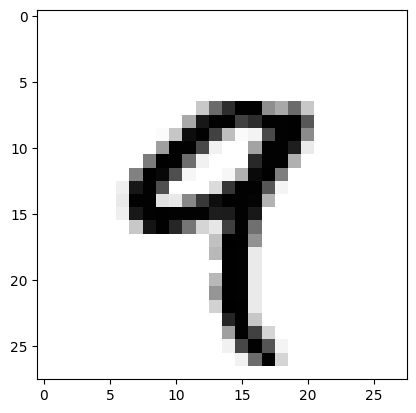

In [26]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show

### Torch:

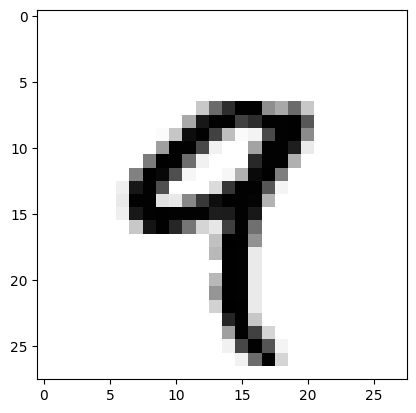

In [27]:
import matplotlib.pyplot as plt
digit = train_ds.data[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

## 2.2.6 Manupulating tensors in Numpy

In [32]:
# tensorflow
my_slice = train_images[10:100]
display(my_slice.shape)
# torch
my_slice_pt = train_ds.data[10:100]
my_slice_pt.shape

(90, 28, 28)

torch.Size([90, 28, 28])

### The notion of data batches

In general, the first axis (axis 0, bacause indexing starts at 0) in all data sensors you will com across in deep learning will be the samples axis (sometimes called the samples dimension). In the MNIST example, samples are images of digits.

In addition, deep learniing models don't process an entire dataset at onece; rather they break the data into small batches, Concretely. here's one batch of our MNIST digits, with a batch size of 128

In [35]:
#---tensorflow---
batch = train_images[:128]
## then next batch
batch = train_images[128:256]
## and The nth batch:
n = 3
batch = train_images[128 * n:128*(n+1)]
#---torch---
batch = train_ds.data[:128]
## tehen next batch
batch = train_ds.data[128:256]
## and the nth batch
n = 3
batch = train_ds.data[128*n : 128*(n+1)]

## 2.2.8 Real-world example of data tensros

The data you'll manipulate will almost always fall into following catagories: 
* ***vector data** *: Rank-2 tensors of shape (sample, fetures), where eatch sample is a vector of numerical attributes ("features")


* ***Timeseries data*** : Rank-3 tensors of shape (samples, timesteps, features), where each sample is a sequence (of length timesteps) of freature vectors


* ***Images*** : Rank-4 tensors of shape (sample, height, width, channels), where each samples is a 2D grid of pixels, and each pixel is represented by a vector of vlues ("Channels")


* ***Video*** : Rank-5 tensors of shape (samples, frames, height, width, channels), where each sample is a sequence (of length frames) of images

## 2.2.9 Vector data
This is one of the most common cases. In such a dataset, each single data point can be
encoded as a vector, and thus a batch of data will be encoded as a rank-2 tensor (that
is, an array of vectors), where the first axis is the samples axis and the second axis is the
features axis.

Let's take at two examples:
* An actuarial dataset of people, where we consider each person’s age, gender,
and income. Each person can be characterized as a vector of 3 values, and thus
an entire dataset of 100,000 people can be stored in a rank-2 tensor of shape
(100000, 3).

* A dataset of text documents, where we represent each document by the counts
of how many times each word appears in it (out of a dictionary of 20,000 common
words). Each document can be encoded as a vector of 20,000 values (one
count per word in the dictionary), and thus an entire dataset of 500 documents
can be stored in a tensor of shape (500, 20000).

## 2.2.10 Timeseries data of sequence data
Whenever time matters in your data (or the notion of sequence order), it makes sense
to store it in a rank-3 tensor with an explicit time axis. Each sample can be encoded as
a sequence of vectors (a rank-2 tensor), and thus a batch of data will be encoded as a
rank-3 tensor.


![sample image](images/1.png)


<!-- <img src="images/1.png" weight="300"/> -->
The time axis is always the second axis (axis of index 1) by convention. Let's look at a few examples:
* A dataset of stock prices. Every minute. we store the current price of the stock the highest price in the past minute, and the lowest price in the past minute. Thus, every minute is encuded as 3D vector, as etire day of trading is ecoded as a matrix as a matrix of shape (390, 3) (there are 390 minutes in the trading data), and 250 days' worth of data can be stored in a rank-3 tensor of shape(250, 390,3). Here each sample would be one day's wordth of data
* A dataset of tweets, were we encode each tweet as a sequence if 289 char out of an alphabet of 128 unique chars. In this setting, each character can be encoded as a binary vector of size 1(an all-zeroes vector exept for a 1 entry at the index correspondeing to the chacter). Then each tweet can be encoded as a rank-2 tensor of shape (289, 128). and a dataset of 1 million tweets can be encoded as a randk-2 tensor of shape (280, 128), and a dataset of 1 million tweets can be stored in a tensor of shape (1,000,000, 280, 128).

### 2.2.11 Image data
Image typically have three dimensions: height, width and color depth. Although grayscale images (like our MNIST digts) have only a single color chanell and could thus be stored in randk 2 tensor. by convertion image tensors are always rank-3, with a one dimensional color cchannel for grayscale images. Ab atch of 128 grauscale images of size 256 x 256 coud thus be stored in a tensor of shape (128, 256, 256, 1), and a batch of 138 color images could be stored in a tensor of shape  (128, 256, 256, 3)


![blablabla](images/2.png)

***Note***:
* Tensorflow standard: ```(sample, height, width, channels)```
* Pytorch standard: ```(sameple, channels, height, width)```

### 2.2.12 Video data
Video data is one of the few types of real-world data for which you’ll need rank-5 tensors.
A video can be understood as a sequence of frames, each frame being a color
image. Because each frame can be stored in a rank-3 tensor (height, width, color_
depth), a sequence of frames can be stored in a rank-4 tensor (frames, height,
width, color_depth), and thus a batch of different videos can be stored in a rank-5
tensor of shape (samples, frames, height, width, color_depth).
For instance, a 60-second, 144 × 256 YouTube video clip sampled at 4 frames per
second would have 240 frames. A batch of four such video clips would be stored in a
tensor of shape (4, 240, 144, 256, 3). That’s a total of 106,168,320 values! If the dtype of the tensor was float32, each value would be stored in 32 bits, so the tensor
would represent 405 MB. Heavy! Videos you encounter in real life are much lighter,
because they aren’t stored in float32, and they’re typically compressed by a large factor
(such as in the MPEG format).

## 2.3 The gears of nerual networks: Tensor operations
A keras layer instance look like this

In [ ]:
from tensorflow import keras
keras.layers.Dense (512, activation='relu')
# output = relu(dot(input, W)+b)

<Dense name=dense, built=False>

In PyTorch dense is **nn.Linear** and you add **ReLU** separately

In [37]:
import torch
from torch import nn
# Example input has 32 batch of 1000 feature
x = torch.rand(32, 1000)
# Dense laryer 1000->512
layer = nn.Linear(1000, 512)
relu = nn.ReLU()

output = relu(layer(x))
print(output.shape)

torch.Size([32, 512])


🧠 What actually happens


If input is shaped [batch_size, 1000]:
*	Multiply by weight matrix W of shape [1000, 512].
*	Add bias vector b of shape [512].
*	Apply activation (e.g. ReLU).


So:

\text{output} = \text{ReLU}(XW + b)
*	Input shape → [batch, 1000]
*	Output shape → [batch, 512]

### 2.3.1 Element-wise operations

native python way relu

In [38]:
def native_relu(x):
    assert len(x.shape) == 2 # x is a rank-2 NumPy tensor
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i,j],0)
    return x

def native_add(x,y):
    assert len(x.shape)==2
    assert x.shape==y.shape
    x = x.copy()
    for i in range (x.shape[0]):
        for j in range(x.shape[1]):
            x[i,j]+=y[i,j]
    return x
    

### 2.3.2 BroadCasting

### 2.3.3 Tensor Product

### 2.3.4 Tensor reshaping

### 2.3.6 Visual representation of tensor manupulation

## 2.4 *(very Important)* ***The engine of neural networkds: Gradient-based optimization***
1. Draw a batch of training samples, x, and corresponding targets, y_true.
2. Run the model on x (a step called the forward pass) to obtain predictions, y_pred.
3. Compute the loss of the model on the batch, a measure of the mismatch between
y_pred and y_true.
4. Update all weights of the model in a way that slightly reduces the loss on this
batch.